<a href="https://colab.research.google.com/github/kalana-mihiranga/Image-Captioning/blob/main/Phase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization
keras.utils.set_random_seed(111)

In [2]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [3]:
IMAGES_PATH = "Flicker8k_Dataset"
IMAGE_SIZE = (255, 255)
VOCAB_SIZE = 10000
SEQ_LENGTH = 25
EMBED_DIM = 512
FF_DIM = 512
BATCH_SIZE = 64
EPOCHS = 40
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
def load_captions_data_samples(filename):
    # Open the caption text file
    with open(filename) as caption_file:
        raw_caption_lines = caption_file.readlines()
        caption_mapping = {}  # Dictionary to map image path to its captions
        text_data = []        # List to store all cleaned caption strings
        images_to_skip = set()  # To track images with invalid caption lengths

        for line in raw_caption_lines:
            # Remove newline characters and split into image name and caption
            line = line.rstrip("\n")
            img_name, caption = line.split("\t")
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # Tokenize the caption
            tokens = caption.strip().split()

            # Skip captions that are too short or too long
            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            # Process valid captions
            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # Add start and end tokens to caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                # Store caption under its image in the dictionary
                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        # Remove any image entries that were flagged for skipping
        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def training_value_split(captions_dict, train_size=0.8, shuffle=True):
    # Extract all image file paths
    all_images = list(captions_dict.keys())

    # Optionally shuffle image paths
    if shuffle:
        np.random.shuffle(all_images)

    # Calculate split point for training and validation sets
    split_index = int(len(captions_dict) * train_size)

    # Create dictionaries for training and validation sets
    training_data = {img: captions_dict[img] for img in all_images[:split_index]}
    validation_data = {img: captions_dict[img] for img in all_images[split_index:]}

    return training_data, validation_data


# Load the caption data and split into training and validation sets
captions_mapping, text_data = load_captions_data_samples("Flickr8k.token.txt")
train_data, valid_data = training_value_split(captions_mapping)

# Print dataset statistics
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))


Number of training samples:  6114
Number of validation samples:  1529


In [5]:
# Define a custom text standardization function for the tokenizer
def normalize_text(input_string):
    # Convert all characters to lowercase
    lowercase = tf.strings.lower(input_string)
    # Remove unwanted punctuation characters except '<' and '>'
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


# Define characters to strip from captions
strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
# Retain < and > tokens since they're used as special markers
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

# Set up a text vectorization layer for tokenizing captions
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,             # Maximum vocabulary size
    output_mode="int",                 # Output token IDs as integers
    output_sequence_length=SEQ_LENGTH, # Pad or truncate sequences to this length
    standardize=normalize_text,        # Use our custom normalization function
)

# Adapt the vectorization layer to the dataset's text data
vectorization.adapt(text_data)

# Define a sequential image augmentation pipeline to increase dataset diversity
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),       # Random horizontal flip
        layers.RandomRotation(0.2),            # Random rotation by ±20%
        layers.RandomContrast(0.3),            # Random contrast adjustment
        layers.RandomZoom(0.1),                # Random zoom-in/out
        layers.RandomTranslation(0.1, 0.1),     # Random shift in width and height
    ]
)


In [6]:
# Function to load an image from disk and preprocess it for the model
def load_and_prepare_image(img_path):
    img = tf.io.read_file(img_path)                         # Read image file
    img = tf.image.decode_jpeg(img, channels=3)             # Decode JPEG to RGB
    img = tf.image.resize(img, IMAGE_SIZE)                  # Resize to desired input size
    img = tf.image.convert_image_dtype(img, tf.float32)     # Normalize pixel values to [0, 1]
    return img

# Function to pair the processed image with its tokenized caption
def process_input_images(img_path, captions):
    return load_and_prepare_image(img_path), vectorization(captions)

# Function to create a tf.data.Dataset pipeline for training/validation
def process_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))  # Create dataset from image-caption pairs
    dataset = dataset.shuffle(BATCH_SIZE * 8)                         # Shuffle for randomness
    dataset = dataset.map(process_input_images, num_parallel_calls=AUTOTUNE)  # Map image-caption processing
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)           # Batch and prefetch for performance
    return dataset

# Generate the training dataset
train_dataset = process_dataset(list(train_data.keys()), list(train_data.values()))

# Generate the validation dataset
valid_dataset = process_dataset(list(valid_data.keys()), list(valid_data.values()))


In [7]:
def build_cnn_feature_extractor():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )

    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        img_embed = self.cnn_model(batch_img)


        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )


                batch_loss += loss
                batch_acc += acc

            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )


            grads = tape.gradient(loss, train_vars)


            self.optimizer.apply_gradients(zip(grads, train_vars))


        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)


        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0
        img_embed = self.cnn_model(batch_img)


        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )


            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)


        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = build_cnn_feature_extractor()
cnn_model.trainable = True
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction=None,
)


class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


#  learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 10
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
history =caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
)

Epoch 1/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 130s 831ms/step - acc: 0.1084 - loss: 37.6850 - val_acc: 0.2922 - val_loss: 21.4664
Epoch 2/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 126s 748ms/step - acc: 0.3064 - loss: 20.7717 - val_acc: 0.3456 - val_loss: 18.3504
Epoch 3/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 760ms/step - acc: 0.3480 - loss: 18.1433 - val_acc: 0.3633 - val_loss: 17.1561
Epoch 4/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 85s 788ms/step - acc: 0.3685 - loss: 16.8318 - val_acc: 0.3765 - val_loss: 16.4645
Epoch 5/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 80s 765ms/step - acc: 0.3833 - loss: 15.9353 - val_acc: 0.3872 - val_loss: 16.0368
Epoch 6/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 84s 785ms/step - acc: 0.3950 - loss: 15.2626 - val_acc: 0.3929 - val_loss: 15.6581
Epoch 7/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 785ms/step - acc: 0.4050 - loss: 14.6975 - val_acc: 0.3966 - val_loss: 15.4941
Epoch 8/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 783ms/step - acc: 0.4152 - loss: 14.2236 - val_acc: 0.4023 - val_loss: 15.2519
Epoch 9/40
96/96 ━━━━━━━━━━━━━

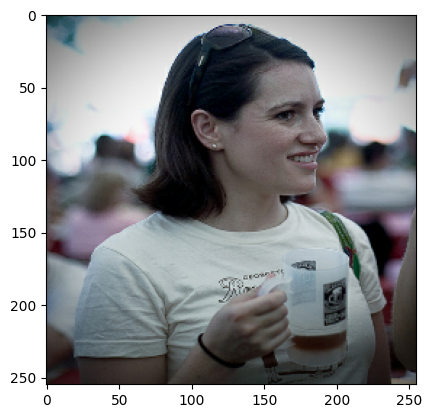

Predicted Caption:  a woman with a backpack is walking past a crowd


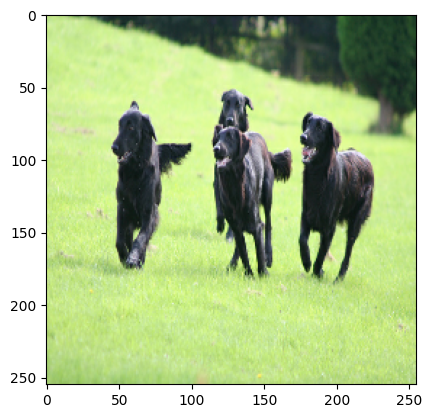

Predicted Caption:  a black dog runs through the grass


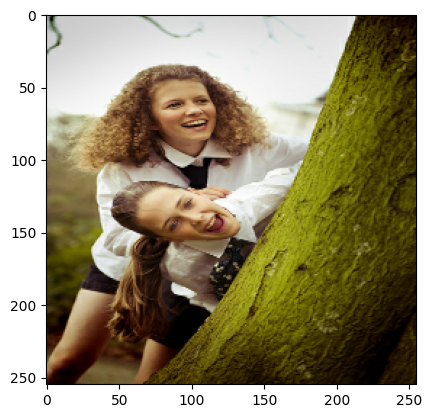

Predicted Caption:  a woman is sitting on a rock in a field of flowers


In [17]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def predict_image_caption():
    #  random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # image from the disk
    sample_img = load_and_prepare_image(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Check predictions for a few samples
predict_image_caption()
predict_image_caption()
predict_image_caption()

In [10]:
caption_model.save("caption_model.h5")
print("✅ Model saved as caption_model.h5")


NotImplementedError: Learning rate schedule 'LRSchedule' must override `get_config()` in order to be serializable.